In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from myutils import data_utils as du

In [2]:
fink_colors_list = ["#15284F", "#F5622E", "#D5D5D3", "#3C8DFF"]
fink_colors_dic = {"FINK":"#15284F", "ZTF":"#F5622E", "TNS":"#D5D5D3"}

In [3]:
mpl.rcParams["font.size"] = 16
mpl.rcParams["legend.fontsize"] = "medium"
mpl.rcParams["figure.titlesize"] = "large"
mpl.rcParams["lines.linewidth"] = 3

# SNe lists

In [4]:
# read TNS labels and apply timeranges for this experiment
df_dic = {}
df_TNS_tmp = du.load_TNS_reformat("../classifications/tns_fink_20230817.parquet",cols_to_add=['redshift'])
df_dic["TNS"] = du.apply_timerange_fink_fup(df_TNS_tmp, ndaysplus=9)
# two types are missing, they are non Ia so AL loop is ok
df_dic["TNS"].loc[df_dic["TNS"]["ztf_names"] == "ZTF24aahsmkt", "type"] = "II"
df_dic["TNS"].loc[df_dic["TNS"]["ztf_names"] == "ZTF23abfpegt", "type"] = "IIB"
df_dic["TNS"].loc[
    df_dic["TNS"]["ztf_names"] == "ZTF24aakaiha", "type"
] = "TDE"  # reclassified from Ia to TDE-He 7/6/24
df_dic["TNS"].loc[df_dic["TNS"]["type"] == "DE", "type"] = "TDE"

# classified by ZTF
df_dic["ZTF"] = df_dic["TNS"][df_dic["TNS"]["reporting_group"] == "ZTF"]

# FINK
tmp0 = pd.read_csv(
    "../classifications/ALbot_with_classifications_curated_original.tsv", sep="\t"
)
tmp0 = pd.merge(tmp0, df_dic["TNS"][["ztf_names", "type",'redshift']], on="ztf_names", how="left")
# nonIa types missing, adding these tags
tmp = pd.read_csv(
    "../classifications/ALbot_with_classifications_curated_original_nonIatypes.csv",
    sep=" ",
)
tmp = tmp.rename(columns={"type": "classtmp"})
df_merged = pd.merge(tmp0, tmp, on="ztf_names", how="left")
df_merged["type"] = df_merged.apply(
    lambda row: row.classtmp if row.type is np.nan else row.type, axis=1
)
df_merged["type"] = df_merged.apply(
    lambda row: row.Classification if row.type is np.nan else row.type, axis=1
)
df_dic["FINK"] = df_merged

# read host information

In [17]:
# df_host_LS = pd.read_csv('../hosts/tns_SNIa_paperAn_legacy.csv')
df_host_LS = pd.read_csv('../hosts/legacy_after_cuts_ZTF_SNIa_paperAn.csv')
print('all lines LS',len(df_host_LS))
df_host_LS = df_host_LS[df_host_LS['top_match_ac']]
print('after cuts',len(df_host_LS))
df_host_LS = df_host_LS.drop_duplicates(keep='first')
print('Without duplicates',len(df_host_LS))

all lines LS 883
after cuts 395
Without duplicates 256


In [18]:
print(len(df_host_LS[df_host_LS['z_spec']>0]))
print(len(df_host_LS[df_host_LS['z_phot_mean']>0]))

38
164


In [19]:
# Find the row with minimum dDLR for each group
# BEWARE NOTNECESSARILY THE GOOD MATCH AS SOME ARE "NOT GALAXIES"
sel = df_host_LS[(df_host_LS['dDLR'] < 4) & (df_host_LS['dDLR'] >0)]
sel = sel[(sel['fracflux_g']<1) | (sel['fracflux_r']<1) | (sel['fracflux_i']<1) | (sel['fracflux_z']<1)]
sel = sel[(sel['mag_g']>10) | (sel['mag_r']>10) | (sel['mag_i']>10) | (sel['mag_z']>10)]
min_rows = sel.loc[sel.groupby('sn_name')['dDLR'].idxmin()]


In [20]:
min_rows[['sn_name','mag_g', 'mag_r', 'mag_i', 'mag_z']]

,sn_name,mag_g,mag_r,mag_i,mag_z
796,ZTF18aaiualk,17.563215,16.741421,inf,16.156096
311,ZTF18aarunfu,17.132366,16.252090,-9999.000000,15.620553
347,ZTF18aatrtkc,17.007566,16.061235,-9999.000000,15.381712
421,ZTF18abxmxbh,18.800875,18.532820,18.443581,18.375748
577,ZTF19abgbbzy,12.566298,11.881724,-9999.000000,11.485037
...,...,...,...,...,...
377,ZTF24aaypock,17.768301,17.260569,-9999.000000,16.898701
378,ZTF24aayucpn,16.774410,16.292070,-9999.000000,16.018509
382,ZTF24aaywvsf,18.783968,18.213718,inf,17.819218
160,ZTF24aazkvzi,18.149574,17.243849,inf,16.535229


In [21]:
def plot_hists(df_dic, var,bins=10,verbose=True):
    min_b = np.min(min_rows[(min_rows[var]>0) & (min_rows[var]<26)][var].min())
    max_b = np.max(min_rows[(min_rows[var]>0) & (min_rows[var]<26)][var].max())
    mybins= np.arange(min_b,max_b+(max_b-min_b)/10,(max_b-min_b)/bins)
    for k in df_dic.keys():
        sel = min_rows[(min_rows['sn_name'].isin(df_dic[k]['ztf_names'])) & (min_rows[var]>0) & (min_rows[var]<26)]
        plt.hist(sel[var], bins=mybins, alpha=0.5, label=k,color=fink_colors_dic[k])
        if verbose:
            print(f"From {len(df_dic[k])} with host-gal & host-mag {len(sel)}")
            print(f"{k} {np.round(sel[var].median(),2)} +- {np.round(sel[var].std(),2)}")
    plt.legend()
    plt.xlabel(var)
    plt.ylabel('# of light-curves')

From 622 with host-gal & host-mag 238
TNS 0.85 +- 0.82
From 256 with host-gal & host-mag 107
ZTF 0.67 +- 0.91
From 96 with host-gal & host-mag 69
FINK 1.07 +- 0.84


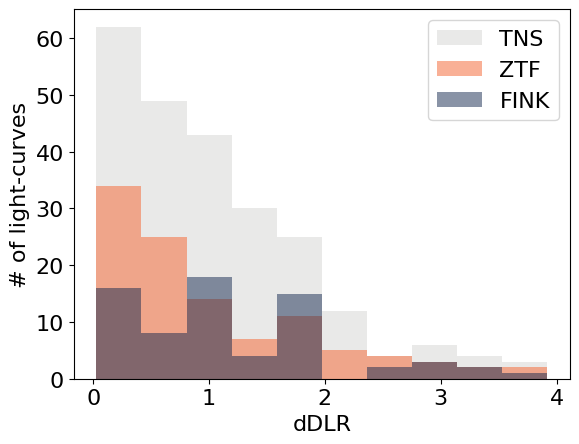

In [22]:

plot_hists(df_dic, 'dDLR')

# are they good matches?

/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_44177/3849265383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dic[k]['sn_name'] = df_dic[k]['ztf_names'].copy()
/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_44177/3849265383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dic[k]['sn_name'] = df_dic[k]['ztf_names'].copy()


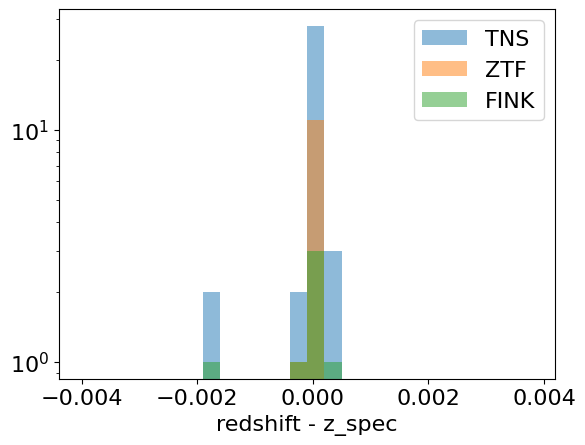

In [23]:

for k in df_dic.keys():
    sel = min_rows[(min_rows['sn_name'].isin(df_dic[k]['ztf_names']))]
    df_dic[k]['sn_name'] = df_dic[k]['ztf_names'].copy()
    sel_merged = pd.merge(sel, df_dic[k], on='sn_name', how='left')
    sel_merged = sel_merged[(sel_merged['redshift']>0) & (sel_merged['z_spec']>0)]
    plt.hist(sel_merged['redshift']-sel_merged['z_spec'], bins=np.arange(-0.004,0.004,0.0003), alpha=0.5, label=k)
plt.legend()
plt.xlabel('redshift - z_spec')
plt.yscale('log')


/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_44177/1344374615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dic[k]['sn_name'] = df_dic[k]['ztf_names'].copy()
/var/folders/hj/2gy38d5s5mj7n7cln0xf7kjh249zrd/T/ipykernel_44177/1344374615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dic[k]['sn_name'] = df_dic[k]['ztf_names'].copy()


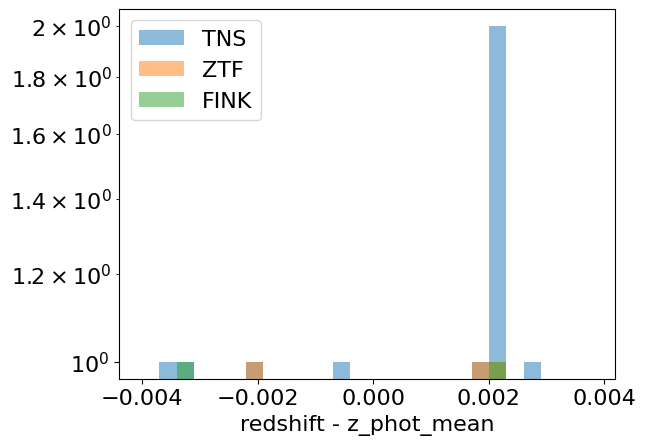

In [24]:

for k in df_dic.keys():
    sel = min_rows[(min_rows['sn_name'].isin(df_dic[k]['ztf_names']))]
    df_dic[k]['sn_name'] = df_dic[k]['ztf_names'].copy()
    sel_merged = pd.merge(sel, df_dic[k], on='sn_name', how='left')
    sel_merged = sel_merged[(sel_merged['redshift']>0) & (sel_merged['z_spec']>0)]
    plt.hist(sel_merged['redshift']-sel_merged['z_phot_mean'], bins=np.arange(-0.004,0.004,0.0003), alpha=0.5, label=k)
plt.legend()
plt.xlabel('redshift - z_phot_mean')
plt.yscale('log')


From 622 with host-gal & host-mag 218
TNS 16.77 +- 2.02
From 256 with host-gal & host-mag 98
ZTF 16.62 +- 2.02
From 96 with host-gal & host-mag 60
FINK 17.48 +- 2.0


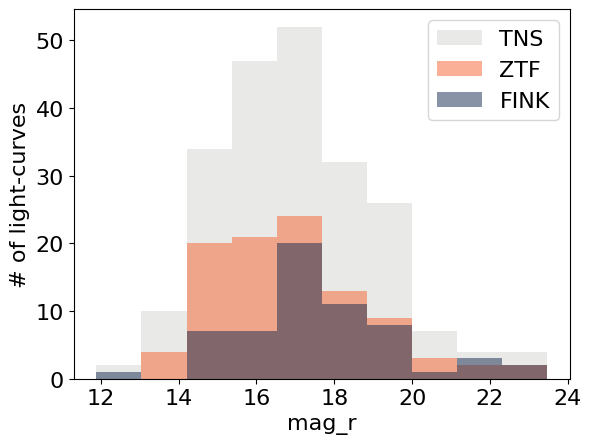

In [25]:
plot_hists(df_dic, 'mag_r',bins=10)

From 622 with host-gal & host-mag 98
TNS 16.98 +- 2.08
From 256 with host-gal & host-mag 34
ZTF 16.98 +- 2.18
From 96 with host-gal & host-mag 43
FINK 17.32 +- 1.95


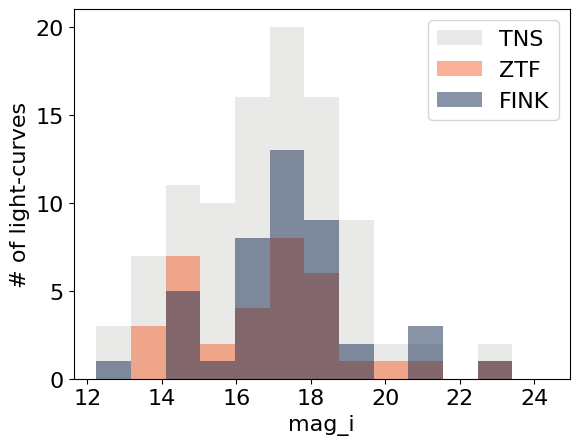

In [26]:
plot_hists(df_dic, 'mag_i',bins=12)

From 622 with host-gal & host-mag 233
TNS 17.55 +- 1.94
From 256 with host-gal & host-mag 104
ZTF 17.33 +- 1.96
From 96 with host-gal & host-mag 67
FINK 18.22 +- 1.92


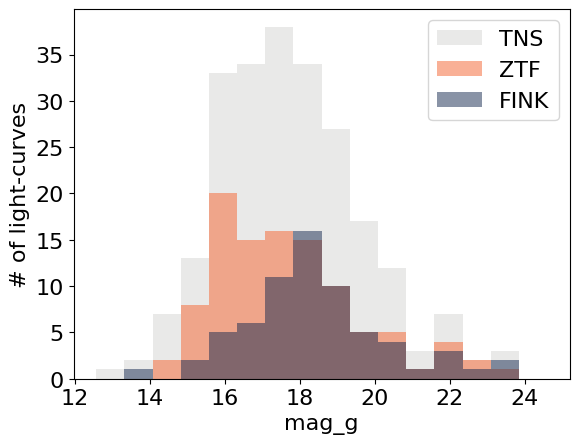

In [27]:
plot_hists(df_dic, 'mag_g',bins=15)

From 622 with host-gal & host-mag 224
TNS 16.28 +- 2.18
From 256 with host-gal & host-mag 99
ZTF 16.03 +- 2.27
From 96 with host-gal & host-mag 62
FINK 17.06 +- 2.03


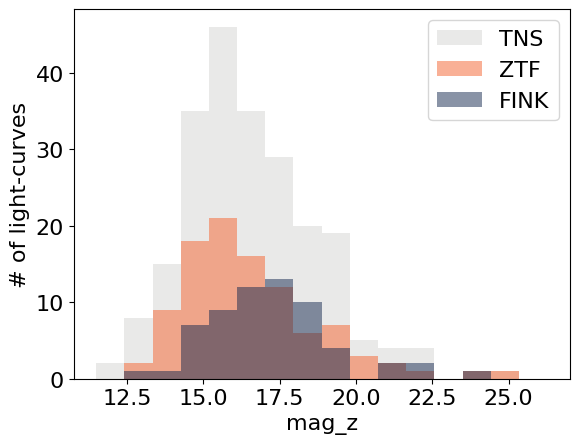

In [28]:
plot_hists(df_dic, 'mag_z',bins=15)

# For Olivia to write in a README or unify
- magnitudes have Nan, inf and -9999.000000 
- what does dDLR -999 means?
- -99 z_spec missing?
- you probably don’t need min_dDLR_ac as it seems to be a repeat of dDLR which has the minimum value.
- a potential bug legacy_after_cuts_ZTF_SNIa_paperAn.csv has some duplicated rows and also some rows were the same SN has different coordinates (e.g. ZTF24aazkvzi)